In [2]:
import json
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from pycocotools import mask as coco_mask  # 避免命名冲突



class TurtleSegmentationDataset(Dataset):
    def __init__(self, annotations_file, images_dir, transform=None):
        with open(annotations_file, 'r') as f:
            self.data = json.load(f)
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data['images'])

    def __getitem__(self, idx):
        # 获取图片信息和路径
        image_info = self.data['images'][idx]
        image_path = os.path.join(self.images_dir, image_info['file_name'])
        image = Image.open(image_path).convert("RGB")
        
        # 初始化类别掩码
        mask_category1 = np.zeros((image_info['height'], image_info['width']), dtype=bool)
        mask_category2 = np.zeros((image_info['height'], image_info['width']), dtype=bool)
        mask_category3 = np.zeros((image_info['height'], image_info['width']), dtype=bool)

        # 遍历分割注释并生成各类别掩码
        for ann in self.data['annotations']:
            if ann['image_id'] == image_info['id']:
                rle = ann['segmentation']
                category_id = ann['category_id']
                
                # 转换 RLE 为二进制掩码
                rle_encoded = coco_mask.frPyObjects(rle, image_info['height'], image_info['width'])
                binary_mask = coco_mask.decode(rle_encoded).astype(bool)
                
                # 根据 category_id 分配到对应的掩码中
                if category_id == 1:
                    mask_category1 |= binary_mask
                elif category_id == 2:
                    mask_category2 |= binary_mask
                elif category_id == 3:
                    mask_category3 |= binary_mask

        # 计算 refined_mask_category1，排除 category 2 和 category 3 的区域
        refined_mask_category1 = mask_category1 & ~mask_category2 & ~mask_category3

        # 创建一个最终的掩码图像
        final_mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
        final_mask[refined_mask_category1] = 1  # 用 1 表示 refined category 1
        final_mask[mask_category2] = 2  # 用 2 表示 category 2
        final_mask[mask_category3] = 3  # 用 3 表示 category 3

        # 调整图像和掩码大小
        image = image.resize((256, 256))
        final_mask = Image.fromarray(final_mask).resize((256, 256), resample=Image.NEAREST)

        # 应用转换
        if self.transform:
            image = self.transform(image)
        final_mask = torch.from_numpy(np.array(final_mask)).long()
        
        return image, final_mask





# 定义数据增强和转换（去除 transforms.Resize）
transform = transforms.Compose([
    transforms.ToTensor()
])

# 加载训练集和测试集
train_dataset = TurtleSegmentationDataset(
    annotations_file='/root/autodl-fs/archive/turtles-data/data/annotations_train.json',
    images_dir='/root/autodl-fs/archive/turtles-data/data',
    transform=transform
)

test_dataset = TurtleSegmentationDataset(
    annotations_file='/root/autodl-fs/archive/turtles-data/data/annotations_test.json',
    images_dir='/root/autodl-fs/archive/turtles-data/data',
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=8)







import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=4):
        super(UNet, self).__init__()
        
        # 定义 U-Net 编码器部分
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # 最大池化
        self.pool = nn.MaxPool2d(2, 2)
        
        # 定义 U-Net 中间部分
        self.bottleneck = self.conv_block(512, 1024)
        
        # 定义 U-Net 解码器部分
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        
        # 最终输出层
        self.conv_final = nn.Conv2d(64, out_channels, kernel_size=1)
        
   
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # 编码器部分
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # 中间层
        bottleneck = self.bottleneck(self.pool(enc4))
        
        # 解码器部分
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        return self.conv_final(dec1)

# 创建 U-Net 模型
model = UNet(in_channels=3, out_channels=4)  # 假设分割有 4 类（背景 + 3 个部位）



import torch.nn as nn
import torch.optim as optim

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, masks)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("训练完成")


# 保存模型权重
torch.save(model.state_dict(), "turtle_segmentation_unet.pth")
print("模型权重已保存。")


# 加载模型权重
model.load_state_dict(torch.load("turtle_segmentation_unet.pth"))
model.eval()  # 切换到评估模式


import torch
import numpy as np

def calculate_iou(pred_mask, true_mask, num_classes):
    ious = []
    for cls in range(num_classes):
        pred = (pred_mask == cls)
        true = (true_mask == cls)
        
        intersection = (pred & true).sum().item()
        union = (pred | true).sum().item()
        
        if union == 0:
            iou = float('nan')  # 如果没有这个类别，则设置为 NaN
        else:
            iou = intersection / union
        ious.append(iou)
    return ious

# 测试并计算 IoU
total_ious = []
model.eval()
with torch.no_grad():  # 禁用梯度计算，节省内存
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        # 获取模型预测
        outputs = model(images)
        pred_masks = torch.argmax(outputs, dim=1)  # 获取类别预测
        
        # 逐张图像计算 IoU
        for i in range(images.size(0)):
            ious = calculate_iou(pred_masks[i].cpu(), masks[i].cpu(), num_classes=4)
            total_ious.append(ious)
            print(f"IoU for sample {i+1}: {ious}")

# 计算所有样本的平均 IoU
total_ious = np.array(total_ious)
mean_iou = np.nanmean(total_ious, axis=0)  # 对每个类别的 IoU 取平均
print(f"Mean IoU for each class: {mean_iou}")
print(f"Mean IoU across all classes: {np.nanmean(mean_iou)}")


Epoch [1/50], Loss: 0.3982
Epoch [2/50], Loss: 0.2550
Epoch [3/50], Loss: 0.2151
Epoch [4/50], Loss: 0.1937
Epoch [5/50], Loss: 0.1727
Epoch [6/50], Loss: 0.1541
Epoch [7/50], Loss: 0.1340
Epoch [8/50], Loss: 0.1182
Epoch [9/50], Loss: 0.1078
Epoch [10/50], Loss: 0.1009
Epoch [11/50], Loss: 0.0897
Epoch [12/50], Loss: 0.0822
Epoch [13/50], Loss: 0.0783
Epoch [14/50], Loss: 0.0727
Epoch [15/50], Loss: 0.0691
Epoch [16/50], Loss: 0.0663
Epoch [17/50], Loss: 0.0606
Epoch [18/50], Loss: 0.0574
Epoch [19/50], Loss: 0.0551
Epoch [20/50], Loss: 0.0530
Epoch [21/50], Loss: 0.0497
Epoch [22/50], Loss: 0.0491
Epoch [23/50], Loss: 0.0454
Epoch [24/50], Loss: 0.0424
Epoch [25/50], Loss: 0.0412
Epoch [26/50], Loss: 0.0431
Epoch [27/50], Loss: 0.0372
Epoch [28/50], Loss: 0.0372
Epoch [29/50], Loss: 0.0356
Epoch [30/50], Loss: 0.0328
Epoch [31/50], Loss: 0.0316
Epoch [32/50], Loss: 0.0335
Epoch [33/50], Loss: 0.0291
Epoch [34/50], Loss: 0.0282
Epoch [35/50], Loss: 0.0284
Epoch [36/50], Loss: 0.0251
E

IoU for sample 1: [0.914561590108356, 0.4713972032820987, 0.5022396416573348, 0.6752767527675276]


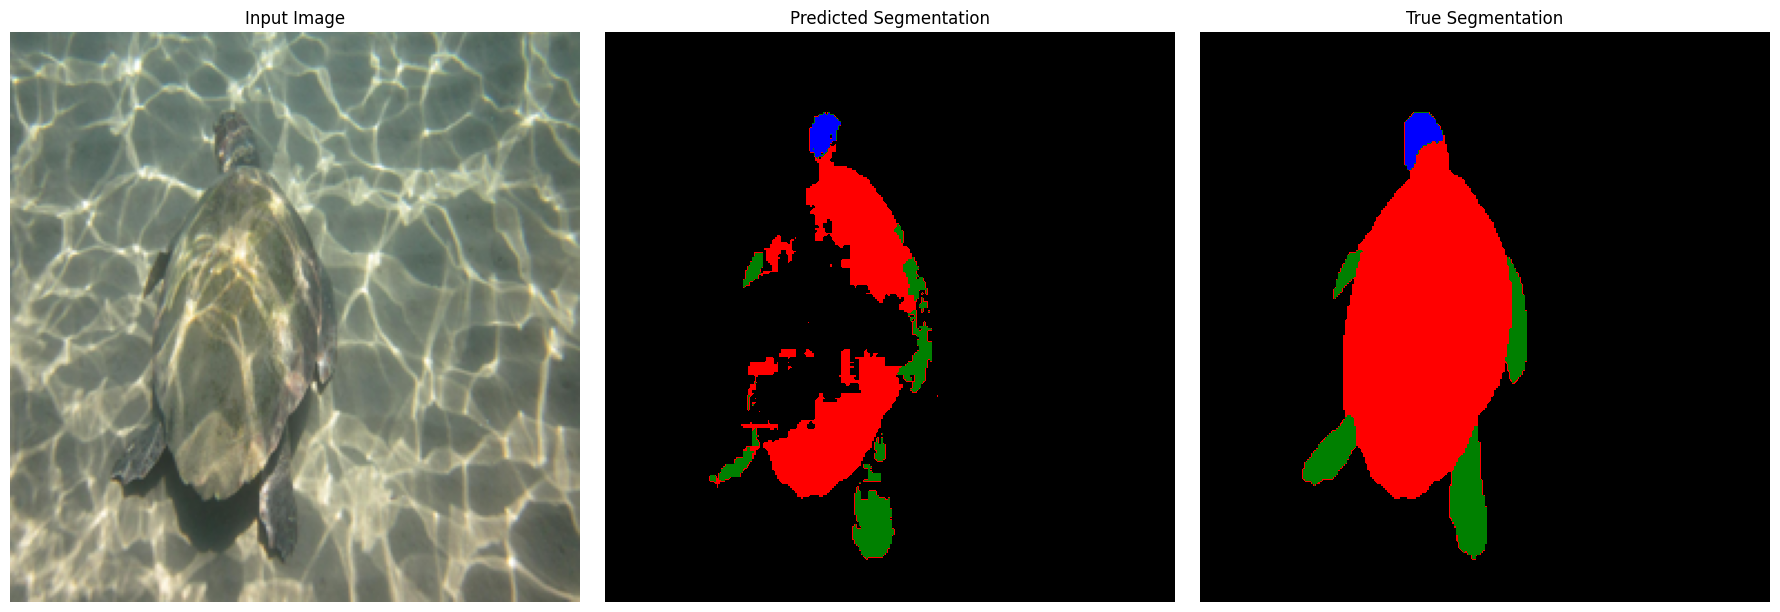

IoU for sample 2: [0.9991333737758905, 0.9659776842875435, 0.9627249357326478, 0.46545454545454545]


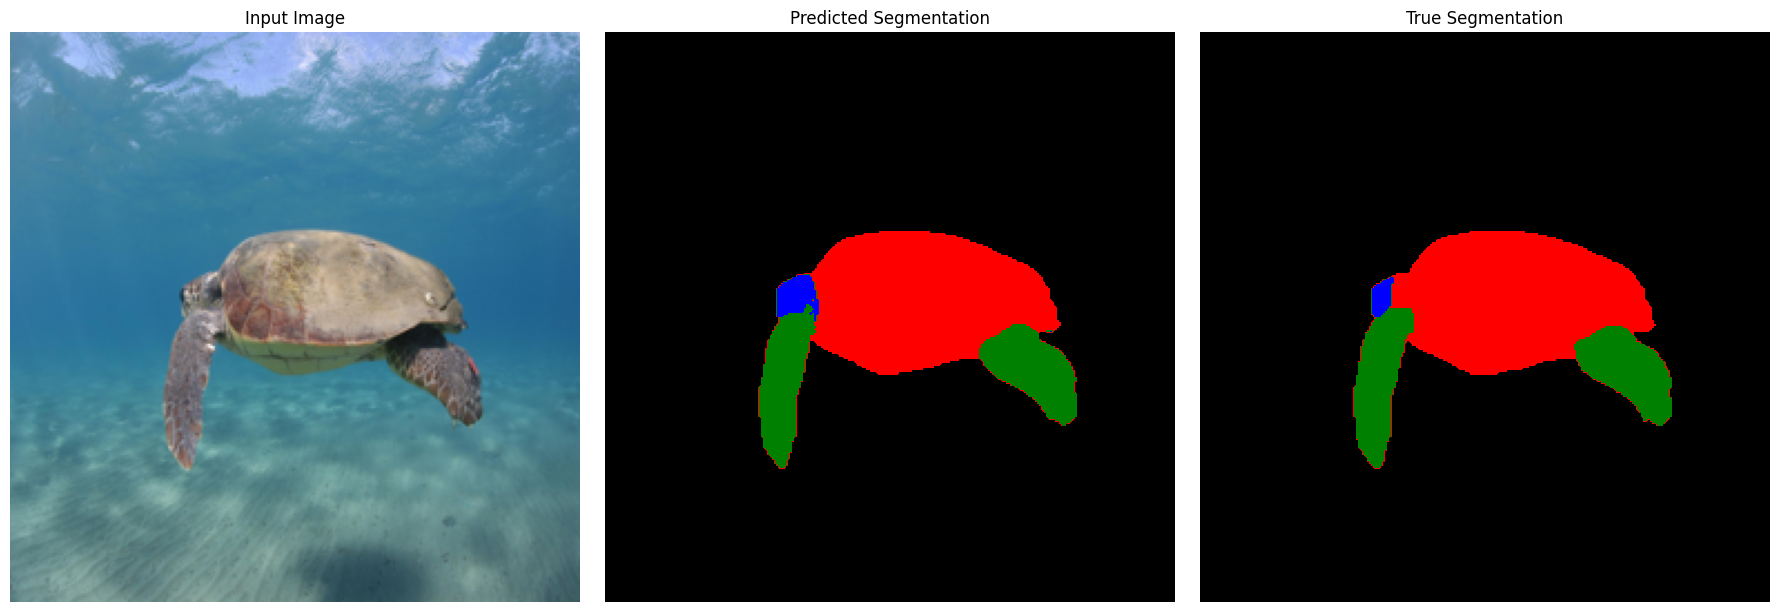

IoU for sample 3: [0.9750227679023172, 0.8079321094561829, 0.47113702623906706, 0.8782771535580525]


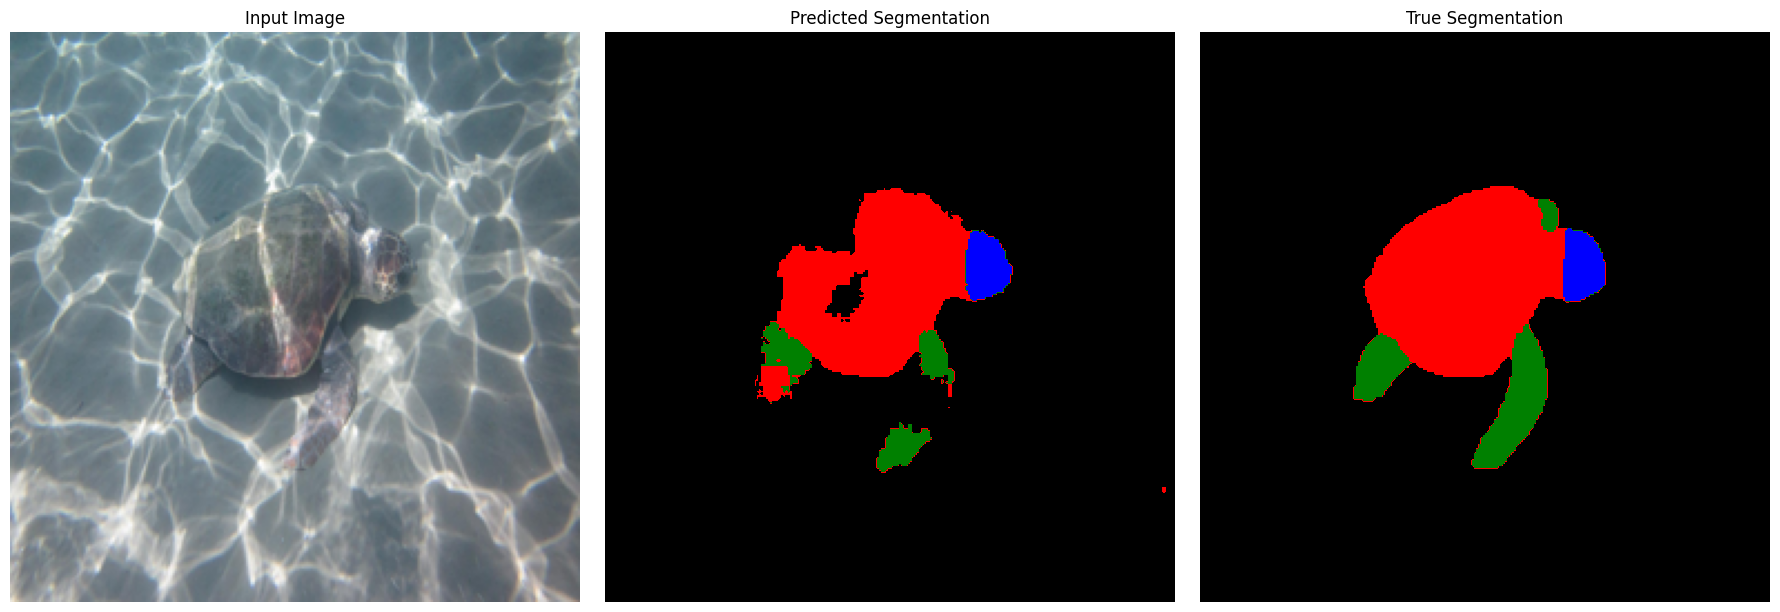

IoU for sample 4: [0.973011874775099, 0.8438348125871048, 0.5430952831975753, 0.6689755741888443]


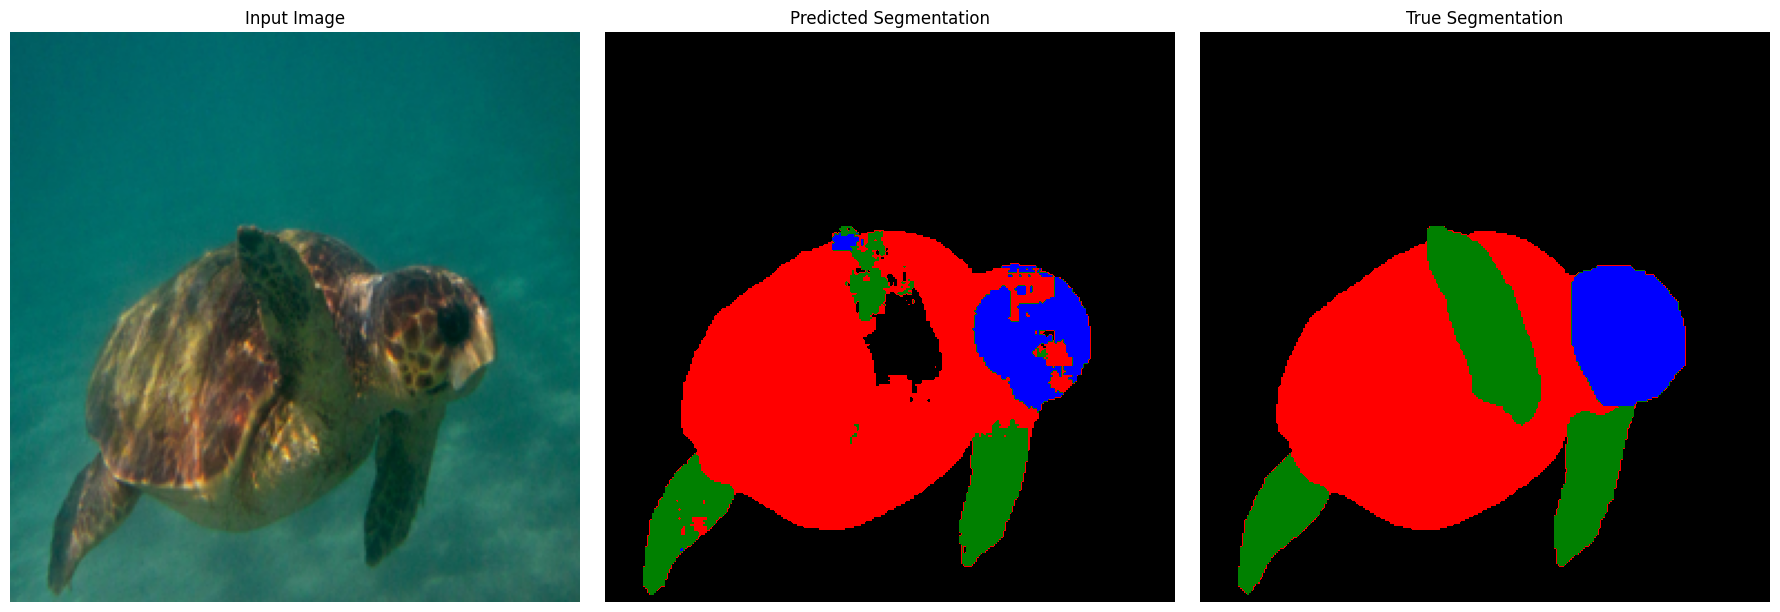

Mean IoU for each class: [0.9654324  0.77228545 0.61979922 0.67199601]
Mean IoU across all classes: 0.7573782705606367


In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from matplotlib.colors import ListedColormap

# 定义每个类别的颜色（假设有4个类别：0、1、2、3）
# 例如：0 - 黑色，1 - 红色，2 - 绿色，3 - 蓝色
class_colors = ['black', 'red', 'green', 'blue']
cmap = ListedColormap(class_colors)

# 定义函数用于在一张图片上显示整体分割结果
def visualize_segmentation(image, pred_mask, true_mask, sample_idx):
    # 将张量转换为 NumPy 格式
    image_np = image.permute(1, 2, 0).cpu().numpy()  # 转换成 (H, W, C)
    pred_mask_np = pred_mask.cpu().numpy()
    true_mask_np = true_mask.cpu().numpy()

    # 创建图形
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # 原图
    ax[0].imshow(image_np)
    ax[0].set_title("Input Image")

    # 整体预测分割显示，使用自定义颜色映射
    ax[1].imshow(pred_mask_np, cmap=cmap, vmin=0, vmax=len(class_colors) - 1)
    ax[1].set_title("Predicted Segmentation")

    # 整体真实分割显示，使用自定义颜色映射
    ax[2].imshow(true_mask_np, cmap=cmap, vmin=0, vmax=len(class_colors) - 1)
    ax[2].set_title("True Segmentation")

    # 设置子图格式
    for a in ax:
        a.axis("off")
    plt.tight_layout()
    plt.show()
    # plt.savefig(f'segmentation_sample_{sample_idx}.png')  # 保存图片（可选）

# 测试并计算 IoU，同时可视化所有类别的分割结果
def calculate_iou(pred_mask, true_mask, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred_mask == cls)
        target_inds = (true_mask == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))  # 忽略背景类别
        else:
            ious.append(intersection / union)
    return ious

total_ious = []
model.eval()
with torch.no_grad():  # 禁用梯度计算，节省内存
    for batch_idx, (images, masks) in enumerate(test_loader):
        images = images.to(device)
        masks = masks.to(device)
        
        # 获取模型预测
        outputs = model(images)
        pred_masks = torch.argmax(outputs, dim=1)  # 获取类别预测
        
        # 逐张图像计算 IoU，并显示分割结果
        for i in range(images.size(0)):
            ious = calculate_iou(pred_masks[i].cpu(), masks[i].cpu(), num_classes=4)
            total_ious.append(ious)
            print(f"IoU for sample {batch_idx * test_loader.batch_size + i + 1}: {ious}")

            # 可视化整体分割结果
            visualize_segmentation(images[i], pred_masks[i], masks[i], sample_idx=batch_idx * test_loader.batch_size + i + 1)
        break

# 计算所有样本的平均 IoU
total_ious = np.array(total_ious)
mean_iou = np.nanmean(total_ious, axis=0)  # 对每个类别的 IoU 取平均
print(f"Mean IoU for each class: {mean_iou}")
print(f"Mean IoU across all classes: {np.nanmean(mean_iou)}")
